<a href="https://colab.research.google.com/github/hargurjeet/Melanoma_Detection_Case_Study/blob/main/Starter_code_Assignment_CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
import zipfile
from zipfile import ZipFile
from google.colab import files
import os
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# specify the path of the ZIP archive you want to extract
zip_file_path = "/content/gdrive/MyDrive/Upgrad/CNN_assignment.zip"

# create a ZipFile object
zip_obj = zipfile.ZipFile(zip_file_path)

# extract all the files and directories from the archive to the current working directory
zip_obj.extractall()

# close the ZipFile object
zip_obj.close()

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
## Checking the current size of image
img_path = r'/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg'

# open the image using PIL
img = Image.open(img_path)

# get the dimensions of the image
width, height = img.size

# print the dimensions of the image
print(f"The dimensions of the image are {width}x{height} pixels.")

The dimensions of the image are 600x450 pixels.


Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ds = datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    seed=123
)

Found 1795 images belonging to 9 classes.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    seed=123
)

Found 444 images belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_indices.keys()
print(class_names)

num_classes = len(class_names)

dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

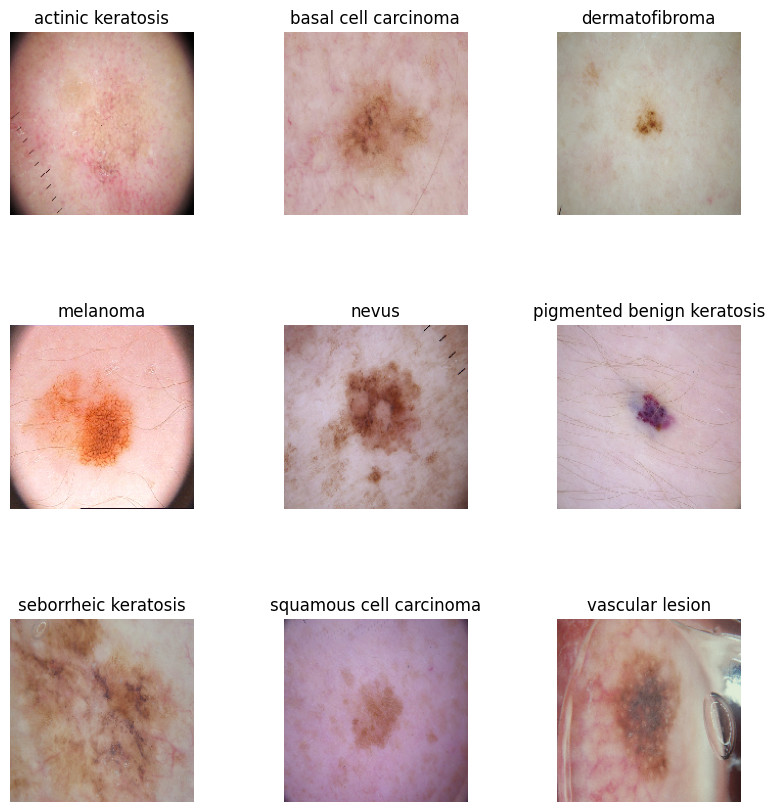

In [11]:
import matplotlib.pyplot as plt

# Get the class names and their integer labels
class_names = list(train_ds.class_indices.keys())
class_labels = train_ds.class_indices

# Create a dictionary to store one image for each class
one_image_per_class = {}

# Loop through the data generator and extract one image for each class
for label in class_labels.values():
    x, _ = train_ds.next()
    while not label in _.argmax(axis=-1):
        x, _ = train_ds.next()
    one_image_per_class[label] = x[_.argmax(axis=-1)[0]]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.6)

for i in range(9):
    img, label = next(train_ds)
    axs[i // 3, i % 3].imshow(img[0])
    axs[i // 3, i % 3].set_title(list(class_labels.keys())[i])
    axs[i // 3, i % 3].axis('off')

plt.show()


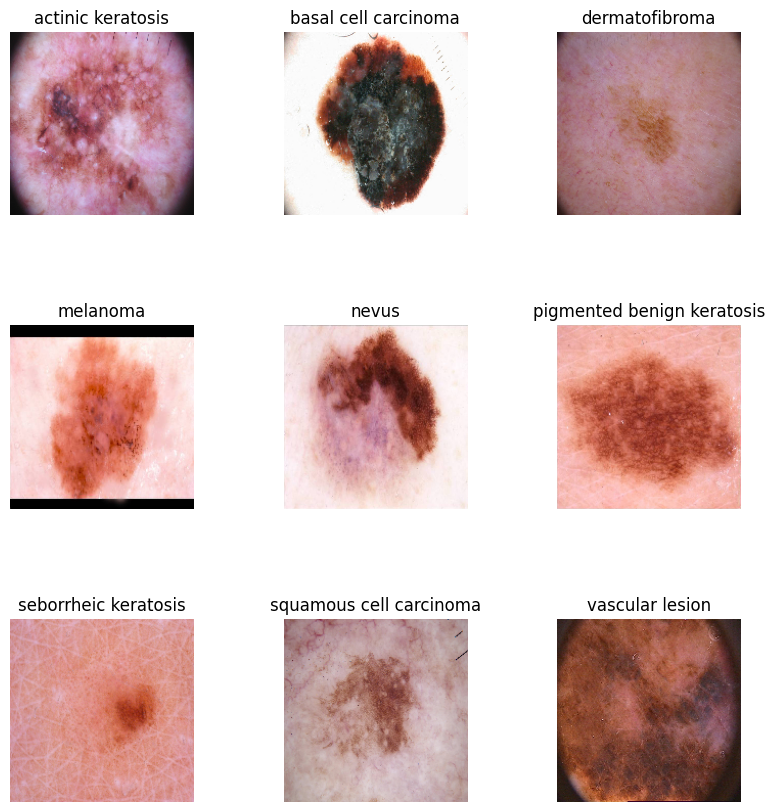

In [12]:
## Visualizing from validation set
# visualize a few images for each class
one_image_per_class = {}

for label in class_labels.values():
    x, _ = val_ds.next()
    while not label in _.argmax(axis=-1):
        x, _ = val_ds.next()
    one_image_per_class[label] = x[_.argmax(axis=-1)[0]]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.6)

for i in range(9):
    img, label = next(val_ds)
    axs[i // 3, i % 3].imshow(img[0])
    axs[i // 3, i % 3].set_title(list(class_labels.keys())[i])
    axs[i // 3, i % 3].axis('off')

plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE


# train_ds = tf.data.Dataset.from_generator(
#     lambda: train_ds,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([None, 180, 180, 3], [None, num_classes])
# )

# val_ds = tf.data.Dataset.from_generator(
#     lambda: val_ds,
#     output_types=(tf.float32, tf.float32),
#     output_shapes=([None, 180, 180, 3], [None, num_classes])
# )

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
model = Sequential()

model.add(Conv2D(filters=75 , kernel_size=(3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,3)))
model.add(MaxPool2D(pool_size=(2,2), strides = 2 , padding = 'same'))

model.add(Conv2D(filters=50, kernel_size=(3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = 2 , padding = 'same'))

model.add(Conv2D(filters=25, kernel_size=(3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())

model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 9 , activation = 'softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 75)      2100      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 50)        33800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 50)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 25)        11275     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 25)       0

### Train the model

In [ ]:
%%time

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

### Visualizing training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- I observe the model is being underfit as the training accuracy increases the val accuracy decreases
- Training and val loss both are going in opposite directions
- Perphas models seems to be not learning well. May be I should improve the feature extraction and some more layer for better learning

### Write your findings here

In [14]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


train_ds = train_datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    seed=123
)

val_ds = train_datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    seed=123
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Generate a batch of augmented images and labels
x_batch, y_batch = train_ds.next()

# Visualize the first 9 images in the batch
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    axs[i].imshow(x_batch[i])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])



### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

### Training the model

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

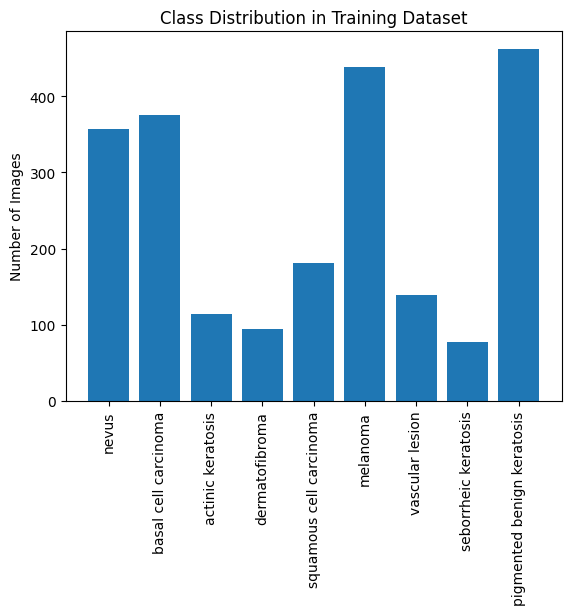

In [17]:
## Your code goes here.

train_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'

# Count the number of images in each class
class_counts = {}
for subdir in os.listdir(train_dir):
    class_counts[subdir] = len(os.listdir(os.path.join(train_dir, subdir)))

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [18]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [19]:
%%time
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=6)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA5A02A59A0>: 100%|██████████| 500/500 [00:38<00:00, 12.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA635BDF160>: 100%|██████████| 500/500 [00:33<00:00, 14.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA635FE8D30>: 100%|██████████| 500/500 [00:29<00:00, 16.92 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x7FA636038940>: 100%|██████████| 500/500 [02:59<00:00,  2.78 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA635FA8970>: 100%|██████████| 500/500 [02:37<00:00,  3.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA635C006D0>: 100%|██████████| 500/500 [00:29<00:00, 16.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA6360321F0>: 100%|██████████| 500/500 [01:15<00:00,  6.65 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6360D17F0>: 100%|██████████| 500/500 [00:29<00:00, 17.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6362BF2B0>: 100%|██████████| 500/500 [00:29<00:00, 16.93 Samples/s]

CPU times: user 16min 16s, sys: 10.4 s, total: 16min 26s
Wall time: 10min 3s


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [20]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [21]:
data_dir_train.glob('*/output/*.jpg')

<generator object Path.glob at 0x7fa62690df20>

In [22]:
list(data_dir_train.glob('*/output/*.jpg'))

[PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000425.jpg_50ba3fd6-1124-431a-a1cf-d0d6c1e1059f.jpg'),
 PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000220.jpg_4d335d94-54ba-4a80-8cc2-c55d46af8a55.jpg'),
 PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026857.jpg_dea71668-eb8c-4773-8c08-d77ca49e914a.jpg'),
 PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000422.jpg_316c50dc-1724-48fe-984d-d631d1df1705.jpg'),
 PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000448.jpg_42d87744-c2d9-49c8-8eda-d6b64d5fb663.jpg'),
 PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_or

In [23]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000425.jpg_50ba3fd6-1124-431a-a1cf-d0d6c1e1059f.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000220.jpg_4d335d94-54ba-4a80-8cc2-c55d46af8a55.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026857.jpg_dea71668-eb8c-4773-8c08-d77ca49e914a.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000422.jpg_316c50dc-1724-48fe-984d-d631d1df1705.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000448.jpg_42d87744-c2d9-49c8-8eda-d6b64d5fb663.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000431.jpg_0fb5597c-a2eb-4c2e-8ce5-730429b52347.jpg'

In [24]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [25]:
path_list_new = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/*/output'
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [26]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2.append(df2)
pd.set_option("max_colwidth", None)
new_df

<ipython-input-26-03afd2b6f84d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df2.append(df2)


,Path,Label
0,/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000425.jpg_50ba3fd6-1124-431a-a1cf-d0d6c1e1059f.jpg,nevus
1,/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000220.jpg_4d335d94-54ba-4a80-8cc2-c55d46af8a55.jpg,nevus
2,/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026857.jpg_dea71668-eb8c-4773-8c08-d77ca49e914a.jpg,nevus
3,/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000422.jpg_316c50dc-1724-48fe-984d-d631d1df1705.jpg,nevus
4,/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000448.jpg_42d87744-c2d9-49c8-8eda-d6b64d5fb663.jpg,nevus
...,...,...
4495,/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027367.jpg_1ea9ef3b-92d3-4d16-b6ad-5f8723f8d454.jpg,pigmented benign keratosis
4496,/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027747.jpg_1864da03-9794-42f0-a79f-41d1cf9afefe.jpg,pigmented benign keratosis
4497,/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027239.jpg_001bae4d-dedb-460a-81e0-c263b5da2ef9.jpg,pigmented benign keratosis
4498,/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025140.jpg_ea4ed068-7692-49df-8d5d-cc6b5f7467e0.jpg,pigmented benign keratosis


In [27]:
new_df['Label'].value_counts()

nevus                         1000
basal cell carcinoma          1000
actinic keratosis             1000
dermatofibroma                1000
squamous cell carcinoma       1000
melanoma                      1000
vascular lesion               1000
seborrheic keratosis          1000
pigmented benign keratosis    1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [44]:
## removing the additional images from the file path
for dir_path in glob(os.path.join(data_dir_train, '*')):
  # Loop over the files in the directory
  for file_name in os.listdir(dir_path):
      
      # Check if the path is a file (not a directory)
      file_path = os.path.join(dir_path, file_name)
      if os.path.isfile(file_path):
          
          # Delete the file
          os.remove(file_path)

In [ ]:
source_dir_list = glob(os.path.join(data_dir_train, '*','output'))
dist_dir_list = glob(os.path.join(data_dir_train, '*'))

## Moving files from output folder to the current train folder
for source_dir, dest_dir in zip(source_dir_list, dist_dir_list):
  print(source_dir, dest_dir)
  # Get list of files in source directory
  file_list = os.listdir(source_dir)

  # Iterate through all files in source directory and move them to destination directory
  for file_name in file_list:
      # Get full path of file in source directory
      src_file = os.path.join(source_dir, file_name)
      # Get full path of file in destination directory
      dest_file = os.path.join(dest_dir, file_name)
      # Move file from source directory to destination directory
      shutil.move(src_file, dest_file)

## Deleting all the source directory
for folder in source_dir_list:
  try:
    os.rmdir(folder)
    print(f"{folder} has been deleted.")
  except OSError as e:
        print(f"Error: {folder} - {e.strerror}.")

/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output has been deleted.
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output has been deleted.
Error: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output - No such file or directory.


#### **Todo**: Train the model on the data created using Augmentor

In [26]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [28]:
data_dir_train= 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

TypeError: ignored

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

